In [2]:
from importlib import reload
import torch
import torch.nn.functional as F
import torch_geometric as pytg
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import train_test_split_edges
from sklearn.metrics import precision_score, recall_score

import data
reload(data)
from data import AmlsimDataset

import modules
reload(modules)
from modules import GCN, GAT

In [3]:
# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [4]:
# Load data
traindata = AmlsimDataset(node_file='data/simulation2/swedbank/train/nodes.csv', edge_file='data/simulation2/swedbank/train/edges.csv', node_features=True, node_labels=True).get_data()
testdata = AmlsimDataset(node_file='data/simulation2/swedbank/test/nodes.csv', edge_file='data/simulation2/swedbank/test/edges.csv', node_features=True, node_labels=True).get_data()
traindata = traindata.to(device)
testdata = testdata.to(device)

/home/agnes/desktop/tnevenv/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
# Normalize data
mean = traindata.x.mean(dim=0, keepdim=True)
std = traindata.x.std(dim=0, keepdim=True)
traindata.x = (traindata.x - mean) / std
testdata.x = (testdata.x - mean) / std

In [6]:
# Instantiate model
in_channels = 10
hidden_channels = 10
out_channels = 2
num_heads = 3
dropout = 0.3
model = GAT(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_heads = num_heads, dropout=dropout)
model.to(device)

GAT(
  (conv1): GATConv(10, 10, heads=3)
  (conv2): GATConv(30, 10, heads=3)
  (conv3): GATConv(30, 2, heads=1)
)

In [60]:
print(type(traindata.edge_index))
print(traindata.edge_index.shape)
# För varje edge_index, i,j, skapa en edge_index, j,i genom att använda ToUndirected
traindata.edge_index=pytg.utils.to_undirected(traindata.edge_index)
testdata.edge_index=pytg.utils.to_undirected(testdata.edge_index)

print(traindata.edge_index.shape)


<class 'torch.Tensor'>
torch.Size([2, 2388])
torch.Size([2, 2388])


In [61]:
# Lite testning!


    


out, aw1, aw2, aw3 = model(traindata.x, traindata.edge_index)
print(out[0])

def get_attention_weights(attention_output):
    edge_index, attention_weights = attention_output
    edge_index, attention_weights = pytg.utils.remove_self_loops(edge_index, attention_weights)
    return edge_index, attention_weights

edge_index, attention_weights = get_attention_weights(aw3)
print(edge_index.shape)
print(attention_weights.shape)

print(edge_index[:,0])
print(attention_weights[0,:])


tensor([-0.1725,  0.1203], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([2, 2388])
torch.Size([2388, 1])
tensor([  0, 858], device='cuda:0')
tensor([0.2603], device='cuda:0', grad_fn=<SliceBackward0>)


In [62]:
# optimizer
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [63]:
# loss function
weight = torch.tensor([1, 5.5], dtype=torch.float32).to(device)
criterion = torch.nn.CrossEntropyLoss(weight = weight)

In [64]:
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out,_,_,_ = model(traindata.x, traindata.edge_index)
    loss = criterion(out, traindata.y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            out,_,_,_ = model(testdata.x, testdata.edge_index)
            loss = criterion(out, testdata.y)
            precision = precision_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
            recall = recall_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
            print(f'epoch: {epoch + 1}, loss: {loss:.4f}, precision: {precision:.4f}, recall: {recall:.4f}')

epoch: 10, loss: 0.8018, precision: 0.5000, recall: 0.3133
epoch: 20, loss: 0.8055, precision: 0.4950, recall: 0.3012
epoch: 30, loss: 0.8166, precision: 0.4900, recall: 0.2952
epoch: 40, loss: 0.8168, precision: 0.4950, recall: 0.3012
epoch: 50, loss: 0.8379, precision: 0.4896, recall: 0.2831
epoch: 60, loss: 0.8362, precision: 0.4896, recall: 0.2831
epoch: 70, loss: 0.8267, precision: 0.4950, recall: 0.3012
epoch: 80, loss: 0.8204, precision: 0.5000, recall: 0.3072
epoch: 90, loss: 0.8171, precision: 0.5143, recall: 0.3253
epoch: 100, loss: 0.8490, precision: 0.4896, recall: 0.2831
epoch: 110, loss: 0.8781, precision: 0.5054, recall: 0.2831
epoch: 120, loss: 0.8656, precision: 0.4896, recall: 0.2831
epoch: 130, loss: 0.8396, precision: 0.4949, recall: 0.2952
epoch: 140, loss: 0.8533, precision: 0.4896, recall: 0.2831
epoch: 150, loss: 0.8426, precision: 0.4950, recall: 0.3012
epoch: 160, loss: 0.8333, precision: 0.5096, recall: 0.3193
epoch: 170, loss: 0.8657, precision: 0.4896, reca

In [65]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
with torch.no_grad():
    out,_,_,_ = model(testdata.x, testdata.edge_index)
    y_pred = out.cpu().numpy().argmax(axis=1)
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

label_0_count = np.count_nonzero(y_true == 0)
label_1_count = np.count_nonzero(y_true == 1)
print(f"Number ground truth labels equal to 0: {label_0_count}")
print(f"Number ground truth labels equal to 1: {label_1_count}")

print(f"recall = {cm[1, 1] / label_1_count}")
print(f"False positive rate = {cm[0, 1] / label_0_count}")

[[352  48]
 [115  51]]
Number ground truth labels equal to 0: 400
Number ground truth labels equal to 1: 166
recall = 0.3072289156626506
False positive rate = 0.12


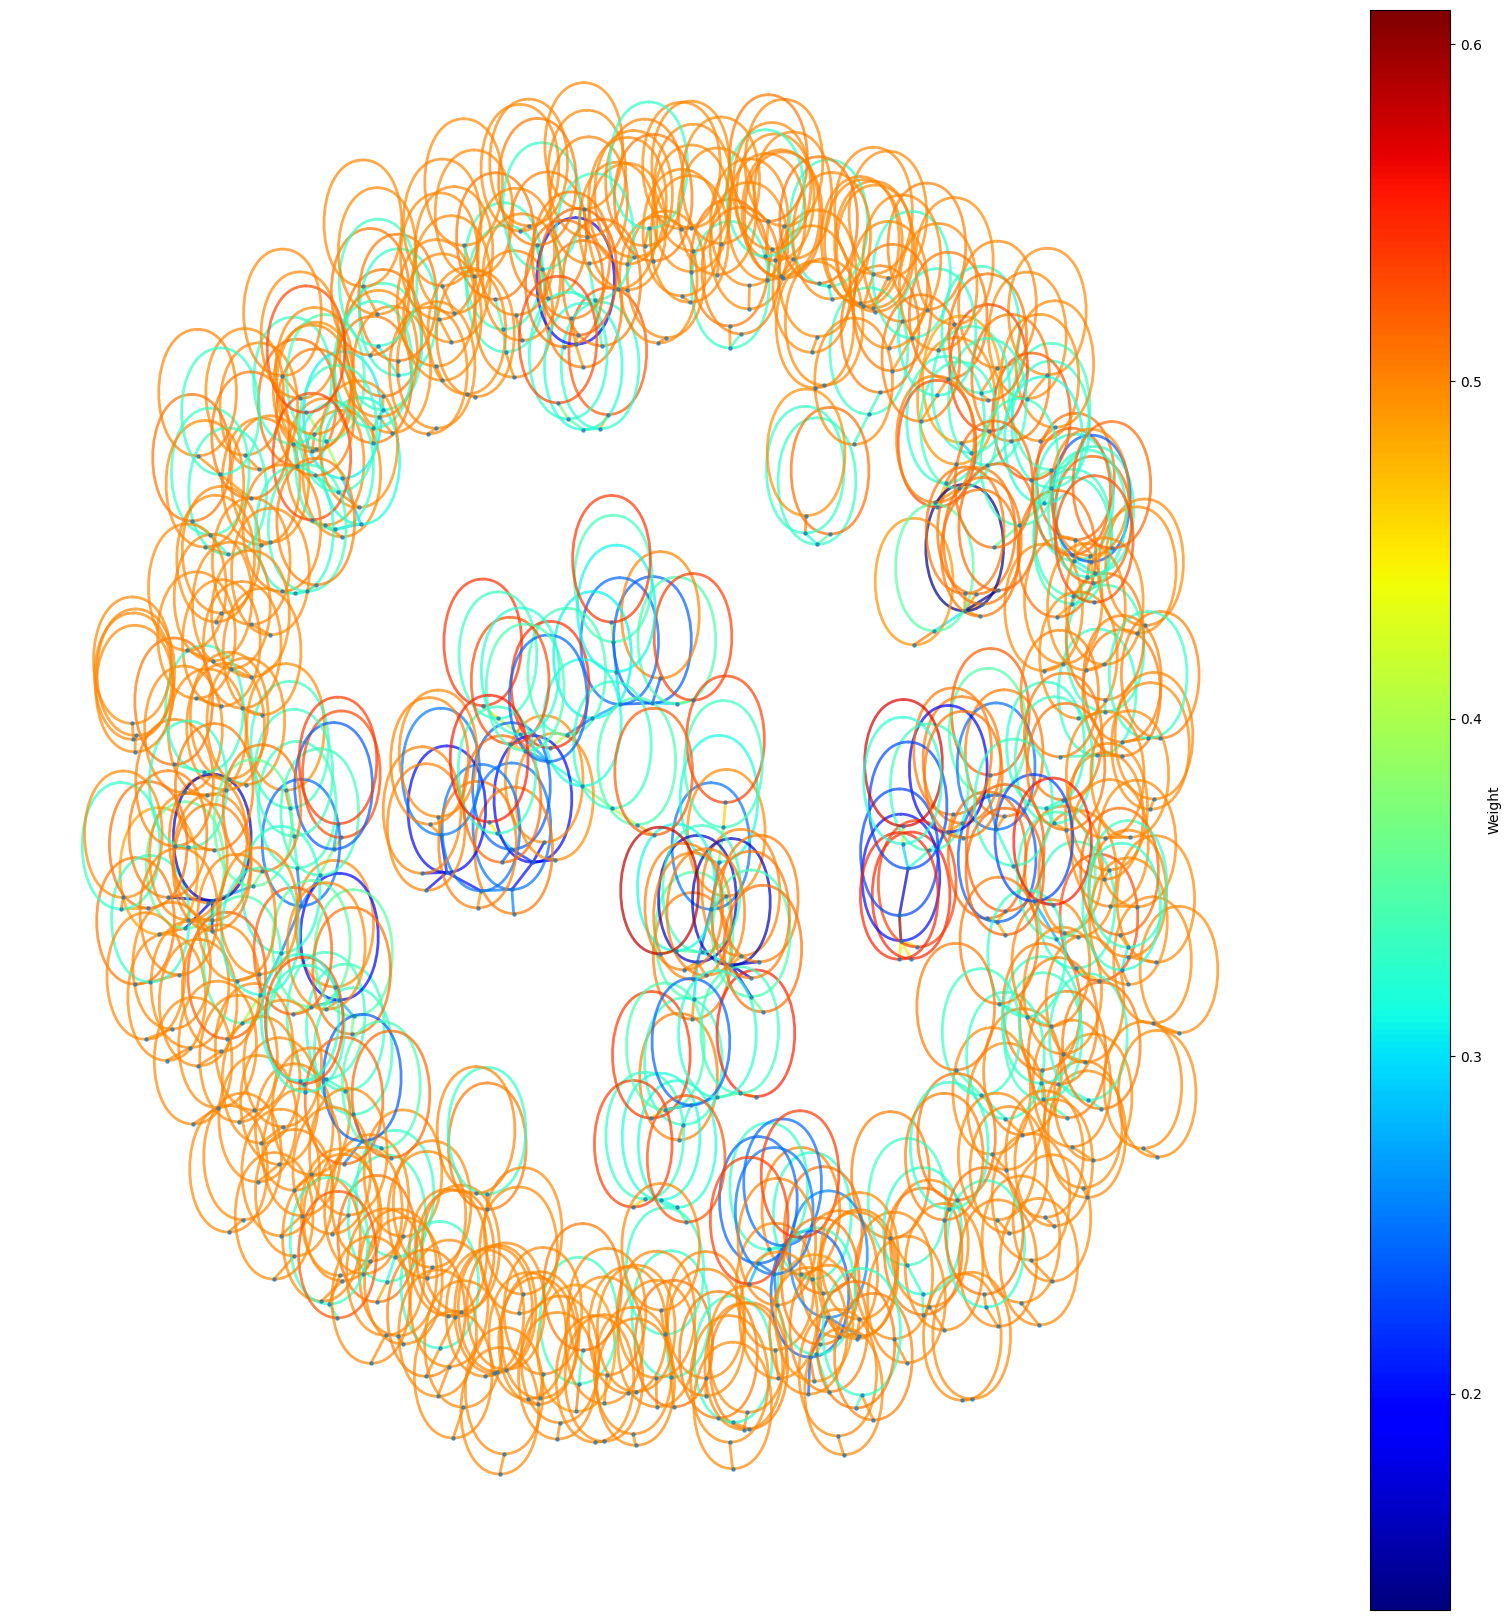

In [66]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Assuming you have your weights in a torch tensor `weights` and edge indices in `edge_indices`
# Create a graph

model.eval()
with torch.no_grad():
    out,aw1,aw2,aw3 = model(testdata.x, testdata.edge_index)

edge_indices, attention_weights = get_attention_weights(aw3)
edge_indices = aw3[0]
attention_weights = aw3[1]

G = nx.Graph()

# Add edges with weights
for i in range(edge_indices.size(1)):
    src, dst = edge_indices[:, i]
    weight = attention_weights[i].item()  # Assuming weights is a torch tensor
    G.add_edge(src.item(), dst.item(), weight=weight)

# Extract edge weights
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Create a colormap based on edge weights
cmap = plt.cm.jet

# Increase the size of the plot
plt.figure(figsize=(16, 16))

# Plot the graph
pos = nx.spring_layout(G)  # Positions of the nodes
nx.draw(G, pos, with_labels=False, edge_color=edge_weights, edge_cmap=cmap, width=2, node_size=5, alpha=0.7)

# Add a color bar to show the mapping of weights to colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
sm.set_array([])
plt.colorbar(sm, label='Weight', ax = plt.gca())

plt.show()


In [17]:
print(type(aw3))
print(len(aw3))


<class 'tuple'>
2


In [82]:
#inspect random node
import random
node_to_inspect = random.randint(0, testdata.num_nodes)

edges = []

for i in range(edge_indices.size(1)):
    column = edge_indices[:, i]
    if column[1] == node_to_inspect:
        edges.append(i)
        print(f"Node {node_to_inspect} and node {column[0]} are connected by edge {i} and has weight {attention_weights[i].item()}")


print(f'Sum of attention weights for node {node_to_inspect}: {attention_weights[edges].sum()}')



Node 199 and node 524 are connected by edge 697 and has weight 0.5
Node 199 and node 199 are connected by edge 973 and has weight 0.5
Sum of attention weights for node 199: 1.0


Edge 1 connects to node 1
Edge 2 connects to node 1
[1, 2]
[[0.37546825]
 [0.35293427]]


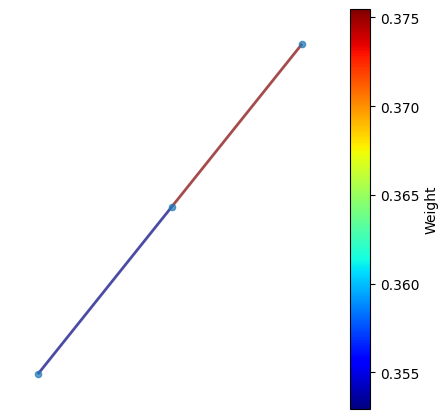

In [21]:
node_to_inspect = 1
edges = []

for i in range(edge_indices.size(1)):
    column = edge_indices[:, i]
    if column[0] == node_to_inspect or column[1] == node_to_inspect:
        edges.append(i)
        print(f"Edge {i} connects to node {node_to_inspect}")

print(edges)
print(attention_weights[edges].to('cpu').numpy())

# Create a graph
G = nx.Graph()

# Add edges with weights
for i in edges:
    src, dst = edge_indices[:, i]
    weight = attention_weights[i].item()
    G.add_edge(src.item(), dst.item(), weight=weight)

# Extract edge weights
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Create a colormap based on edge weights
cmap = plt.cm.jet

# Increase the size of the plot
plt.figure(figsize=(4,4))

# Plot the graph
pos = nx.spring_layout(G)  # Positions of the nodes
nx.draw(G, pos, with_labels=False, edge_color=edge_weights, edge_cmap=cmap, width=2, node_size=20, alpha=0.7)

# Add a color bar to show the mapping of weights to colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
sm.set_array([])
plt.colorbar(sm, label='Weight', ax=plt.gca())

plt.show()

